# SBML support

The simulation script described in this chapter is available at [STEPS_Example repository](https://github.com/CNS-OIST/STEPS_Example/blob/master/user_manual/source/sbml_importer.ipynb).

The SBML module requires access to [libSBML](http://sbml.org/Software/libSBML) with the Python API. Please see [Getting Started](getting_started.ipynb).

## Introduction

STEPS provides thorough and well-validated support for SBML (see Hucka M. et al, (2003) *The Systems Biology Markup Language (SBML): A Medium for Representation and Exchange of Biochemical Network Models. Bioinformatics 9(4):524-531*) in module [steps.utilities.sbml](API_1/API_utilities_sbml.rst). A lot of effort has gone into making sure STEPS supports as many SBML components as possible and, although it would be very difficult in STEPS (or in a stochastic simulator in general) to support every feature, testing has shown that STEPS can import the majority of the SBML Test Suite models and 'curated' Biomodels. STEPS achieves this largely through support for MathML by representation of a MathML expression in a kind of nested Python list (whose members may be state variables that are updated during simulation) and by providing an internal function to solve the mathematics during simulation. This is crucially important because so many components of SBML require MathML support, including Function Definitions, Initial Assignments, Assignment Rules, Rate Rules, Reaction Kinetic Laws, Event Triggers, Event Assignment and more. This also means that STEPS can examine the form of a mathematical expression, which is very important for Reactions. For Reaction Kinetic Laws, STEPS breaks down the form of the mathematics and compares to what can be represented in a fundamental reaction in STEPS, providing an approximate method when the intended mathematics does not follow the intrinsic mathematics (in the deterministic limit). Any simulator that ignored the reaction mathematics in this case would simulate the model incorrectly. This point will be explained in more detail in section [Reaction Kinetic Maths of unexpected form](sbml_importer.ipynb#Reaction-Kinetic-Maths-of-unexpected-form).

## Level of support

### Supported

In short, STEPS supports SBML components:

* Function Definitions
* Unit Definitions
* Compartments (3D and 2D)
* Species
* Parameters
* Initial Assignments
* Rules (Assignment and Rate)
* Reactions (including reversible reactions) (certain criteria apply)
* Events


#### Reactions
 

In supporting 2D and 3D compartments STEPS can also support multi-compartment reactions. Examples are transport reactions from one volume to another, ligand-receptor binding reactions, and reactions where all reactants are embedded in a 2D surface. So STEPS supports volume-volume, volume-surface and surface-surface reactions. However if a reaction includes reactants that are in different volumes, such a reaction is not supported.

STEPS places an upper limit of 4 on reaction stoichiometry, and does not support partial stoichiometry. The rules apply to all solvers, including the deterministic solver, in part because model specification comes before solver choice.

One possible source of discrepancy between simulators is the treatment of a reaction with no reactant molecules present in the system. In such a case, the reaction in STEPS will never fire regardless of the reaction maths, which may not be dependent on the amount of reactant molecules. In any reaction reactants should be destroyed at the same rate as products are produced (an exception to this behaviour is if a reactant population is 'clamped' to some value, which is supported in SBML and STEPS) and if there are in fact no reactant molecules and the reaction were to fire due to some maths that does not depend on the reactant population this should push reactant numbers into unphysical, negative numbers. In STEPS negative concentrations are not allowed, nor do we clamp the reactant number at zero in such a case and allow the reaction to fire, and this is a possible difference from the behaviour of some other simulators.

### Not Supported

STEPS does not support Algebraic Rules nor Constraints.

STEPS does not support compartment dimensions other than 3D and 2D, including 'dimensionless' compartments.

#### Reaction Kinetic Maths of unexpected form


Reaction Kinetic Law maths of a form that is not expected is supported, but by an approximate method. In SBML a reaction contains a 'KineticLaw' element, the mathematics of which defines the 'speed' at which a reaction takes place. This 'speed' can be anything- the mathematics does not have to follow any particular rules, though usually will involve reactants and modifiers in some way. Fundamental to the stochastic chemical kinetics in STEPS and similar simulators is that a reaction is governed by a single constant, often called the 'stochastic chemical constant' or similar, which does not change at least between every reaction event. This means that the maths representing the 'speed' of a reaction (in the deterministic limit) has a well-defined form: for example, in a simple system containing just the simple first order reaction:

\begin{equation}
A\overset{k}{\rightarrow}B
\end{equation}

The equation for the rate, or speed, of this reaction in the deterministic limit is simply the constant, k, multiplied by the number of 'A' molecules available, and this is the maths that we would expect to see in SBML to be able to support this reaction in STEPS with an unchanging stochastic reaction constant. That is, if the substance units for 'A' in SBML are concentration, then the number of 'A' molecules is:

\begin{equation}
A*V
\end{equation}

where `V` is the volume of the compartment, and the Kinetic Law maths for the 'speed' of the reaction would be:

\begin{equation}
k*A*V
\end{equation}

The rule in STEPS is simple: if the kinetic law maths is of the form expected and (when represented in the STEPS stochastic simulation algorithm) results in STEPS in the deterministic limit would be equal to a differential equation solver of the reaction maths, then the reaction is imported and solved normally with the single reaction constant governing behaviour. If the Kinetic Law maths is in any different form, this effectively means that the stochastic reaction constant is in fact not constant and may change during simulation as state variables change. In this case the reaction can be represented in STEPS with an approximate method. The reaction mathematics (in the Kinetic Law element) is saved and can return the reaction speed at any point during the simulation. This speed can be used to update the reaction constant in the STEPS reaction. Such updates occur during :func:`steps.utilities.sbml.Interface.updateSim` function call. This does mean that these reactions are not solved with the exactness of fundamental SSA reactions, but a reasonable time-step for the update can often be found that does not slow simulations unnecessarily and maintains acceptable accuracy.

We should note that the above consideration is separate from changing values within the Kinetic Law maths, such as changing compartment volumes or even varying rate constants, which are supported in fundamental reactions in STEPS. Such variations are separate from the `form` of the maths and, in the STEPS context, assumed to vary insignificantly over a simulation step. Such varying simulation parameters may be found in Rules in SBML, which are fully supported (with the exception of Algebraic Rules).


### SBML Test Suite

To give an idea of the level of support for SBML in STEPS, we have run the SBML Test Suite, validating simulator output. Of the first 900 test models STEPS successfully imports 643 with results validated to the given Test Suite solution. The imports that fail can be split mostly into 3 categories, which are:

* Algebraic Rules included in model (Algebraic rules are not supported as was mentioned in [Not Supported](sbml_importer.ipynb#Not-Supported).)
* 0D and 1D compartment dimensions (compartments must be 3D or 2D for STEPS import, as mentioned in [Not Supported](sbml_importer.ipynb#Not-Supported).)
* No chemical species in the SBML model (chemical species are required for any STEPS simulation).

### Support for MathML

We have tried to include as much MathML support as possible, largely based on what can be represented by basic types in Python and within the `math` module, and includes all maths in the SBML Test Suite and from a large number of the Biomodels database models. MathML support in the STEPS SBML importer currently extends to:

* relational operators: eq, neq, gt, lt, geq, leq
* arithmetic operators: +, -, *, /, power, root, abs, exp, ln, log, floor, ceiling
* logical operators: and, or, not
* trigonometric operators: sin, cos, tan, sinh, cosh, tanh, arcsin, arccos, arctan
* constants: pi, true, false, exponentiale
* other: lambda, piecewise

and of course integer and floating-point numbers.

We believe that this is a high level of support, sufficient for the vast majority of models, but if there is something that we have overlooked that a user would like supported the STEPS developers would be very happy to accept requests for building on the MathML support at steps.dev@gmail.com.

## Other considerations

### Units

STEPS follows the correct rules for unit interpretation, although some cases are unclear and serves for some possible ambiguities in interpretation, perhaps the biggest source of errors for software SBML support. The potential for possible ambiguity arises from the fact that the unit attribute for all parameters and other values, such as compartment volumes, is optional.

SBML models contain (optional) declaration of model units for time, volume, substance etc. Firstly STEPS reads and employs any declared model units, or assumes s.i. units for anything that is undeclared with the exception of litre for volume. This default behaviour can be altered by giving keyword arguments to the [steps.utilities.sbml.Interface](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface) constructor.

STEPS does not support many of the units available in SBML (for example becquerel, lux, tesla etc), though these are rarely used. The supported units are the only units that appear in the vast majority of models, which are:

* dimensionless
* item
* litre
* metre
* mole
* second

### Default volume

For many SBML models that are clearly intended for deterministic modelling compartment dimensions are often set to size 1 so as to avoid any confusion between substances and concentrations in various mathematical expressions. The default assumption would then be that the compartment's volume is one litre, or one unit of whatever the model volume units are. However, the real size of the system becomes more important in stochastic solvers, not just in terms of simulation efficiency but also in the behaviour of the system. In fact it is not possible in STEPS to run a discrete simulation with a molecule count larger than the maximum unsigned integer for any species, and highly recommended that counts should be much lower for simulation efficiency considerations. The question is therefore what to do in STEPS to run such models stochastically. STEPS allows the user to provides a default volume in these cases, although this is not a perfect solution since many SBML models include amounts rather than concentrations and altering the volume size makes no difference at all to the number of molecules injected. This may cause inconsistencies too, for example if a model contained an event that is specified to fire when amount of species 'X' is equal to 1 mole. The best way to deal with such problems is to alter the SBML file itself to run in more realistic spatial scales, which may be as simple as changing the model units of substance and volume, although the [steps.utilities.sbml.Interface](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface) constructor does also provide arguments for changing the default model units if not explicitly declared in the SBML file. STEPS also provides many methods for changing any state variable such as compartment volumes and species amounts either on individual objects such as the [steps.geom.Comp](API_1/API_geom.rst#steps.API_1.geom.Comp) object to alter the volume of some compartment, or even solver methods if appropriate.

In models of large substance amounts and volumes, without manipulation the model may be run in the unoptimized deterministic solver (since molecules number has no baring on simulation time), and this is indeed the solver used for validation purposes.

In any case, care should be taken when the geometry description in the SBML file consists of compartments of size 1 with no specified units.


## SBML file import solution

### Structure of code

Importing an SBML model for simulation in STEPS is very simple, and can be achieved with a minimum of just 6 lines of Python code. However, to explain in further detail some of the points mentioned previously in the chapter and to introduce other considerations we will, as usual, look at an example script that could be used to import an SBML file to STEPS, looking at the code in detail as we go. Our simple example will provide a function to import an SBML file, run the simulation in STEPS and plot results in Matplotib.

As usual, we'll start by importing our STEPS and outside modules, this time adding ``steps.utilities.sbml`` to our imports:


In [1]:
import steps.rng as srng
import steps.solver as ssolver
import steps.utilities.sbml as ssbml
import numpy
from pylab import *

Now we'll create a function to import and run the model defined in the SBML file. We'll give the name of the SBML file as a string to the function arguments, along with some simulation parameters (the simulation end time, the data-collection time-step and number of iterations), which solver to use (our choices are `Wmdirect` and ``Wmrk4``) and a dictionary of species that we wish to plot (if known) to a plot colour. We'll also allow for the default volume units to be changed, and a value to be specified for the default volume in the model, which we will look at in more detail later:


    def runSBMLmod(sbmlFile, time_end, time_dt, iter_n = 1, solver = 'Wmdirect', specs_plot = {}, vol_units = 1.0e-3, vol_def = False):

Our intention for this function should be clear; when we call it we want it to find the SBML file, import to STEPS, run the simulation and plot the results of the chemical species that we are interested in. If we don't specify which species to plot we want the function to plot every species in the model.

### SBML file import

Within our function body, the first thing we'll do is to read the SBML file, converting the model into STEPS components, contained in a [steps.model.Model](API_1/API_model.rst#steps.API_1.model.Model) object and a [steps.geom.Geom](API_1/API_geom.rst#steps.API_1.geom.Geom) object. We achieve this by creating a [steps.utilities.sbml.Interface](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface) object, which at a minimum only requires one argument to the object constructor, the SBML file path as a string:

    iSbml = ssbml.Interface(sbmlFile, volunits_def = vol_units, volume_def = vol_def)

The ``volunits_def`` argument requires a little more explanation. Quite often in SBML files the units for some or all components of the model remain undefined. The way that we deal with this ambiguity is to assume that if a unit is undefined it is the accepted base or derived s.i. unit (e.g. substance:mole, time:second). However, this sometimes causes problems when we come to volumes and concentrations. The s.i derived unit for volume is the cubic meter, which means that the s.i derived unit for concentration is mole per cubic meter, and reaction constants would be based on cubic meters, i.e. a second order reaction constant should have units of metres cubed per mole.second. However, this assumption does not usually match chemical kinetics convention where the base unit for volume is the litre, which can cause problems with our approach if some units are defined in the model and some are not. Therefore the **default behaviour of the STEPS importer is to assume that the units for volume (and anything derived from volume such as concentration and reaction constants) in the model are litres** (``volunits_def = 1.0e-3``) **unless explicitly declared not to be** (for example: ``volunits_def = 1.0``). The default units can be changed to anything, though we require some base reference which is s.i. units of cubic meters. So ``volunits_def = 1.0`` will set the default volume units to cubic metres, ``volunits_def = 1.0e-18`` will set to femtolitres and so on. Since litres are the default unit, the second argument to the above constructor may not usually be required, though is included so that we can change it if necessary. Default units may also be declared for time and substance (area and length will be based on volume units) as described in [steps.utilities.sbml.Interface](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface). Of course if all units are defined within the SBML model then the default value makes no difference, but units are often undefined at least for some components.

The third argument is another volume consideration and is the way that we provide for the user to specify a default volume, given in s.i. units of cubic metres. This is a way to attempt to rescale the model to allow for stochastic modelling, any compartment with size = 1.0 and no units will be set to this default value. This is however not 100% effective if, for example, amounts are injected instead of concentrations and therefore the volume makes no difference to the number of molecules injected, or compartments are explicitly declared to be large compartments.

### Biochemical model and Geometry description

If our import was successful we can now get information about the imported model from the [steps.utilities.sbml.Interface](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface) object we created. Particularly we can fetch a reference to the [steps.model.Model](API_1/API_model.rst#steps.API_1.model.Model) and [steps.geom.Geom](API_1/API_geom.rst#steps.API_1.geom.Geom) objects that were created during import:

    mdl = iSbml.getModel()
    mesh = iSbml.getGeom()

These two simple function calls form the bulk of the interface to the STEPS SBML importer. The [steps.utilities.sbml.Interface](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface) object contains a lot of information about the imported model, but we don't need to provide many new interface methods to access that information. The reason for this is simple- the STEPS objects themselves contain all the information we need and we can call their methods to find out information about the model or to tweak the conditions before simulation. For example, if we wanted to access a list of reactions we simply first call method ``getAllVolsyss()`` on our [steps.model.Model](API_1/API_model.rst#steps.API_1.model.Model) container object (:func:`steps.model.Model.getAllVolsyss`) to return a tuple of all volume systems in the model, then call method ``getAllReacs()`` on each of our [steps.model.Volsys](API_1/API_model.rst#steps.API_1.model.Volsys) objects (:func:`steps.model.Volsys.getAllReacs`) to return tuples of all reactions contained in each volume system. On each [steps.model.Reac](API_1/API_model.rst#steps.API_1.model.Reac) object we may then access it's methods to find information about or even alter the reaction stoichiometry, rate constant etc should we so wish to.

Let's look at an example of utilising the methods within the STEPS objects to find out some information that we want for our simulation, though this is not actually part of the the interface to the SBML importer. When importing an SBML model we might not know what chemical species are present in the system, nor to which compartment they belong, so lets create a dictionary of compartment IDs to a list of all all species (by ID) that reside in each compartment (recall that a species may only be present in one compartment in SBML). We'll also update a dictionary of all species to plot if that was absent from our function constructor (argument ``specs_plot``).

First we create an empty dictionary to map compartment ID to species IDs, and also a boolean to see if the function received any instructions about which species to plot:

    comp_specs = {}
    if not specs_plot: got_sp = False
    else: got_sp = True

Now we run a for loop over all compartments in the model, by using [steps.geom.Geom](API_1/API_geom.rst#steps.API_1.geom.Geom) method `getAllComps` (:func:`steps.geom.Geom.getAllComps`) which will return a tuple of all [steps.geom.Comp](API_1/API_geom.rst#steps.API_1.geom.Comp) objects representing the compartments in the model by reference, find the ID of the compartment with [steps.geom.Comp](API_1/API_geom.rst#steps.API_1.geom.Comp) method `getID` (:func:`steps.geom.Comp.getID`), and for each compartment create an empty list which we will later fill with species IDs:

    for comp in mesh.getAllComps():
        comp_specs[comp.getID()] = []

Next we fetch all the volume systems in the compartment. Recall that a compartment in STEPS stores volume systems by strings and not object references since the two belong in separate namespaces:

        volsys_strings = comp.getVolsys()

Now we loop over each volume system (string) in the compartment and fetch an object reference using [steps.model.Model](API_1/API_model.rst#steps.API_1.model.Model) method `getVolsys` (:func:`steps.model.Model.getVolsys`), and when we have the volume system object reference we can find a tuple of all the species contained in all the reaction and diffusion rules in that volume system with [steps.model.Volsys](API_1/API_model.rst#steps.API_1.model.Volsys) method `getAllSpecs` (:func:`steps.model.Volsys.getAllSpecs`):

        for vsys_str in volsys_strings:
            vsys = mdl.getVolsys(vsys_str)
            specs = vsys.getAllSpecs()

And now finally, still within the volume system loop, loop over the species adding the ID to our dictionary, and also adding to our plotting dictionary if none was given to our constructor (and therefore the default behaviour if we received no instructions will be to plot all species in the model):

            for spec in specs:
                comp_specs[comp.getID()].append(spec.getID())
                if (got_sp == False): specs_plot.update({spec.getID():''})

If the indentation is a little confusing here is the for loop in full:

    for comp in mesh.getAllComps():
        comp_specs[comp.getID()] = []
        volsys_strings = comp.getVolsys()
        for vsys_str in volsys_strings:
            vsys = mdl.getVolsys(vsys_str)
            specs = vsys.getAllSpecs()
            for spec in specs:
                comp_specs[comp.getID()].append(spec.getID())
                if (got_sp == False): specs_plot.update({spec.getID():''})

Finding out what chemical species are in the model and in which compartment is a common simulation requirement and is chosen as an example here to demonstrate why no extra methods are necessary in the STEPS SBML importer to get this information that was parsed from the SBML file- all the information in present in the created STEPS objects themselves, which we can access with [steps.utilities.sbml.Interface](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface) methods :func:`steps.utilities.sbml.Interface.getModel` and :func:`steps.utilities.sbml.Interface.getGeom`.

We move on to simply sorting our species IDs, since it may be a little tidier to do so, and also find out the total number of chemical species in the model. Knowing how many there are allows us to set up our structures for recording data:

    comp_specs_n = 0
    for comp in comp_specs:
        comp_specs[comp].sort()
        comp_specs_n += len(comp_specs[comp])

We set up our data structures much as in previous chapters. There is occasionally some discrepancy with the length of Numpy arrays and it is sometimes necessary to resize the array if filled to and including the last time point, so we'll do that here:

    time_pnts = numpy.arange(0.0, time_end, time_dt)
    points_n = int(round(time_end/time_dt))
    if (len(time_pnts)  == (points_n + 1)): time_pnts = numpy.delete(time_pnts, len(time_pnts)-1)

And our usual data structure for recording data. Our first dimension is the number of iterations to run the simulation (an argument to the main function with default value 1), the second dimension is the total time-points, and the 3rd dimension is all the species in all the compartments in the system. That means that for every simulation run we will record the concentration of all species in the model at every time-point, though this is of course not always necessary:

    res = numpy.zeros([iter_n, points_n, comp_specs_n])

Not forgetting that we have to create our random number generator as usual, and present it with some seed value:

    r = srng.create('mt19937', 256)
    r.initialize(7233)

### Simulation with well-mixed solver

Now we can create our solver object. Although STEPS is designed with stochastic simulation in mind, there is an unoptimized deterministic solver which may be a better choice for some SBML models, particularly when species substance units are amounts in the molar range giving very large numbers of molecules:

    if (solver == 'Wmdirect'):
        sim = ssolver.Wmdirect(mdl, mesh, r)
    elif (solver == 'Wmrk4'):
        sim = ssolver.Wmrk4(mdl, mesh, r)
        sim.setDT(0.0001)
    else:
        raise NameError("Unsupported solver. SBML importer accepts well-mixed solvers 'Wmrk4' and 'Wmdirect'")

And we are ready to run our simulation. First loop over our simulation iterations and reset our simulation object each time. We also need to reset our interface object, because state variables will be changed with every iteration:

    for it in range (0, iter_n):
        sim.reset()
        iSbml.reset()

Now comes an important method for the STEPS SBML importer, which is the [steps.utilities.sbml.Interface](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface) method `setupSim` (:func:`steps.utilities.sbml.Interface.setupSim`). We give this function a reference to our simulation object and the function will set all our initial conditions, which includes of course the initial values for all components in the model, but also takes into account changes that can be made in Initial Assignments and Assignment rules (i.e. an Initial Assignment might change a compartment volume, species concentration, reaction rate constant etc before simulation):

        iSbml.setupSim(sim)

We have now set up our initial conditions (and now we could use solver methods to find any information we wanted to about those conditions) and so we come to running the simulation, which we do by accessing a time-point from our numpy array and record species concentrations, much as is previous chapters:

        for tp in range(0, points_n):
            sim.run(time_pnts[tp])
            i = 0
            for comp in comp_specs:
                for spec in comp_specs[comp]:
                    res[it, tp, i] = sim.getCompConc(comp, spec)
                    i+=1

But before exiting the loop there is one more very important thing to do, and that is to call [steps.utilities.sbml.Interface](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface) method `updateSim` ([steps.utilities.sbml.Interface.updateSim](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface.updateSim)). This function call is vital for correct SBML import in STEPS- it will update anything in the model which is not contained within a fundamental chemical reaction (imported from SBML reactions), which include Rules and Events and also approximate reactions as described in [Reaction Kinetic Maths of unexpected form](sbml_importer.ipynb#Reaction-Kinetic-Maths-of-unexpected-form). A Rule may alter just about anything in the model, including species numbers, compartment volumes, reaction rate constants etc and an Event may also alter a number of things in the model when the trigger condition switches from False to True (for a full explanation please refer to SBML documentation). Both Rules and Events are supported in STEPS and well-validated, though both may only be checked and updated at a simulation time-point. This is due to simulator structure and also stochastic chemical kinetics assumptions, namely that such parameters are constant between each reaction event. It is important that we can assume that any such changing parameter values vary only very slightly during a simulation time-step, which we achieve by keeping time-steps small; though at what dt we can say that parameters changes are small enough not to cause errors will vary from model to model. We could even go as accurate as updating the parameters after every reaction event (using solver method `sim.step()` instead of `sim.run()` to stop the simulation after every single reaction event) for as much accuracy as possible, though we may find that this is usually too slowing and doesn't appreciably change results from a larger, fixed time-step.

We update the simulation parameters. To the [steps.utilities.sbml.Interface](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface) method `updateSim` ([steps.utilities.sbml.Interface.updateSim](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface.updateSim)) we give two arguments: the first is a reference to the solver object (which allows for the method to update simulation parameters) and the second argument is simply a number telling the function how long we ran the simulation for since the last update:

            iSbml.updateSim(sim, time_dt)

Just to be clear, our full simulation loop is then simply:

        for tp in range(0, points_n):
            sim.run(time_pnts[tp])
            i = 0
            for comp in comp_specs:
                for spec in comp_specs[comp]:
                    res[it, tp, i] = sim.getCompConc(comp, spec)
                    i+=1
            iSbml.updateSim(sim, time_dt)

Finally, we find our mean behavior and plot, much as in previous chapters so this will not be explained in detail:

    mean_res = numpy.mean(res, 0)
    i=0
    for comp in comp_specs:
        for spec in comp_specs[comp]:
            if (spec in specs_plot):
                if (specs_plot[spec]): plot(time_pnts, mean_res[:,i], label = spec+ ", "+ comp, color = specs_plot[spec])
                else: plot(time_pnts, mean_res[:,i], label = spec+ ", "+ comp)
            i+=1
    legend(loc = 'best', numpoints=1)
    xlabel('Time (s)')
    ylabel('Conc (M)')
    show()

### Complete code

For clarity, our uninterrupted code is:


In [2]:
def runSBMLmod(sbmlFile, time_end, time_dt, iter_n = 1, solver = 'Wmdirect', specs_plot = {}, vol_units = 1.0e-3, vol_def = False):
        iSbml = ssbml.Interface(sbmlFile, volunits_def = vol_units, volume_def = vol_def)
        mdl = iSbml.getModel()
        mesh = iSbml.getGeom()
        comp_specs = {}
        if not specs_plot: got_sp = False
        else: got_sp = True
        for comp in mesh.getAllComps():
            comp_specs[comp.getID()] = []
            volsys_strings = comp.getVolsys()
            for vsys_str in volsys_strings:
                vsys = mdl.getVolsys(vsys_str)
                specs = vsys.getAllSpecs()
                for spec in specs:
                    comp_specs[comp.getID()].append(spec.getID())
                    if (got_sp == False): specs_plot.update({spec.getID():''})
        comp_specs_n = 0
        for comp in comp_specs:
            comp_specs[comp].sort()
            comp_specs_n += len(comp_specs[comp])
        time_pnts = numpy.arange(0.0, time_end, time_dt)
        points_n = int(round(time_end/time_dt))
        if (len(time_pnts)  == (points_n + 1)): time_pnts = numpy.delete(time_pnts, len(time_pnts)-1)
        res = numpy.zeros([iter_n, points_n, comp_specs_n])
        r = srng.create('mt19937', 256)
        r.initialize(7233)
        if (solver == 'Wmdirect'):
            sim = ssolver.Wmdirect(mdl, mesh, r)
        elif (solver == 'Wmrk4'):
            sim = ssolver.Wmrk4(mdl, mesh, r)
            sim.setDT(0.0001)
        else:
            raise NameError("Unsupported solver. SBML importer accepts well-mixed solvers 'Wmrk4' and 'Wmdirect'")
        for it in range (0, iter_n):
            sim.reset()
            iSbml.reset()
            iSbml.setupSim(sim)
            for tp in range(0, points_n):
                sim.run(time_pnts[tp])
                i = 0
                for comp in comp_specs:
                    for spec in comp_specs[comp]:
                        res[it, tp, i] = sim.getCompConc(comp, spec)
                        i+=1
                iSbml.updateSim(sim, time_dt)
        mean_res = numpy.mean(res, 0)
        i=0
        for comp in comp_specs:
            for spec in comp_specs[comp]:
                if (spec in specs_plot):
                    if (specs_plot[spec]): plot(time_pnts, mean_res[:,i], label = spec+ ", "+ comp, color = specs_plot[spec])
                    else: plot(time_pnts, mean_res[:,i], label = spec+ ", "+ comp)
                i+=1
        legend(loc = 'best', numpoints=1)
        xlabel('Time (s)')
        ylabel('Conc (M)')
        show()

### SBML Interface methods

Our important SBML interface calls, which should be used in all STEPS SBML imports were:

    # Create the interface object, assuming default volume units to be litre.
    iSbml = ssbml.Interface(sbmlFile, volunits_def = vol_units, volume_def = vol_def)

    # Fetch a reference to the created steps.model.Model container object
    mdl = iSbml.getModel()

    # Fetch a reference to the steps.geom.Geometry container object
    mesh = iSbml.getGeom()

    # Reset the SBML interface object:
    iSbml.reset()

    # Set up the initial conditions
    iSbml.setupSim(sim)

    # Update the parameters which may vary in Rules and Events during simulation
    iSbml.updateSim(sim, time_dt)

### Example import function usage

As an example use of our function, lets import a model which we downloaded from the BioModels database (see Li C. et al., (2010) *BioModels Database: An enhanced, curated and annotated resource for published quantitative kinetic models. BMC Syst Biol., 4:92.*), model #98, see Goldbeter A.  et al. (1990) *Minimal model for signal-induced Ca2+ oscillations and for their frequency encoding through protein phosphorylation. Proc Natl Acad Sci USA 87(4):1461-5*, that is a model which contains both exact and approximate reactions, in to the same directory, running the simulation in solver 'Wmrk4' for 10 seconds, collecting data and updating the sim every 0.01 seconds with function call:


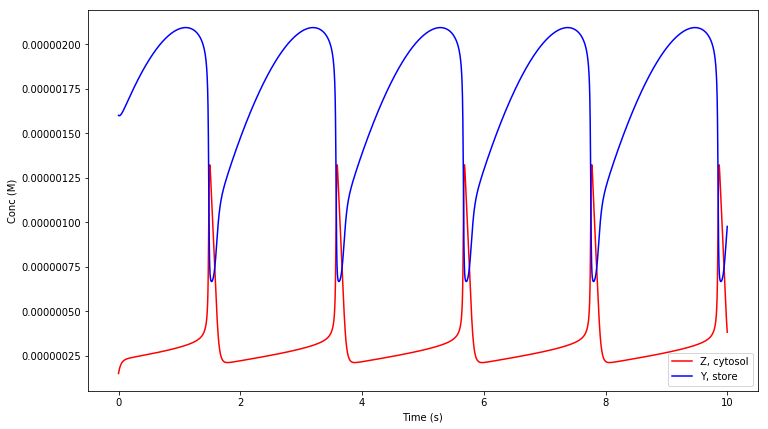

In [3]:
figure(figsize=(12,7))
runSBMLmod('biomodel/BIOMD0000000098.xml', 10, 0.001, \
           solver='Wmrk4',specs_plot={'Y':'blue', 'Z':'red'})

We used the deterministic solver for this model since the amounts of the chemical species are in the micromolar range and the simple unaltered geometry description means that compartments will be given a default volume of 1 litre. The figure below shows the simulation result [obtained from MathSBML](http://www.ebi.ac.uk/biomodels-main/simulation-result.do?uri=publ-model.do&mid=BIOMD0000000098), compared to the above function call producing the results in STEPS shown in above. Although axis labels do not appear on the SBML figure substance units are micromolar, and time units are undefined and so assumed to be seconds in STEPS.

![sbml fig1](images/sbml_fig1.jpg)


Because this model contains concentration injections, the simple geometry description (both compartments in the model are size 1 with no units defined) is suitable for alteration for a stochastic simulation by only changing the default volume assumption. That is we can tell STEPS what to do with a 'default volume' in the model- one of size 1 with no specified units. We alter the default volume with keyword argument `volume_def` to the [steps.utilities.sbml.Interface](API_1/API_utilities_sbml.rst#steps.API_1.utilities.sbml.Interface) constructor, which will be set to whatever value we supply to the runSBMLmod function as argument `vol_def`. The `volume_def` argument value should be given in s.i. units of cubic metres, so if we wanted to set the default compartment volumes to one femtolitre we would give the value 1.0e-18. We also change our choice of solver to the stochastic solver `Wmdirect`:


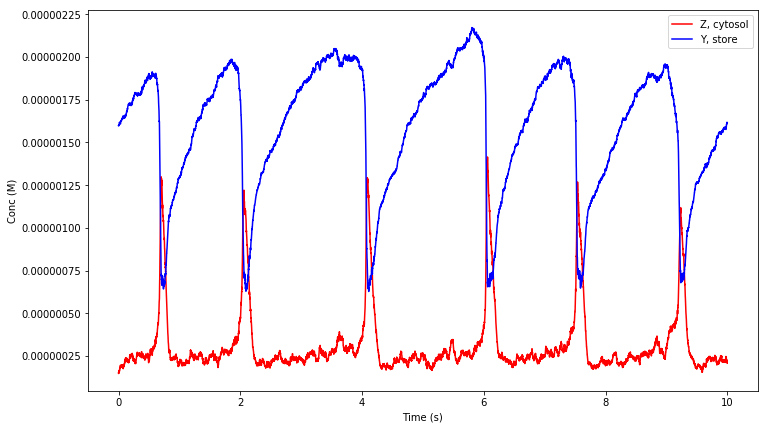

In [4]:
figure(figsize=(12,7))
runSBMLmod('biomodel/BIOMD0000000098.xml', 10, 0.001, \
           solver='Wmdirect',specs_plot={'Y':'blue', 'Z':'red'}, vol_units = 1.0e-3, vol_def = 1.0e-18)